# Packages

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
import osmnx as ox
import rasterio
import pycrs
from rasterio.plot import show, show_hist
from rasterio.mask import mask
from rasterio.merge import merge
from shapely.geometry import box
from fiona.crs import from_epsg
from rasterstats import zonal_stats

import json
import glob
import urllib
from urllib.error import HTTPError, URLError

import os
os.getcwd()

'c:\\Users\\gilramolete\\OneDrive - UNIONBANK of the Philippines\\Documents 1\\Geospatial Analysis\\Automating GIS Processes'

# Automatize data download

For this lesson, we need to download data from couple of different places. For this purpose, we will show how to download data automatically using Python programming which might be quite useful thing to know.

The data files that we are using in this tutorial will be obtained from PaITuli spatial data service. We will be using Landsat 8 image from Helsinki area produced by NASA, USGS & Latuviitta which I have already clipped to reduce the size of the file (raster files are often fairly large in size), and a 2mx2m Digital Elevation Model (DEM) produced by National Land Survey of Finland.

You can download those files into your computer automatically with following script in which we will be using urllib module to download the data with Python:

In [123]:
def get_filename(url):
    '''Parses filename from given url'''

    if url.find('/'):
        return url.rsplit('/', 1)[1]

# Filepaths
outdir = os.getcwd() + '/data/L5/Automate'

# File locations
url_list = ["https://github.com/Automating-GIS-processes/CSC/blob/9e5b5713b9af528c35959e6739da5d0f7944548a/source/notebooks/L5/data/L4133A.tif",
            "https://github.com/Automating-GIS-processes/CSC/blob/9e5b5713b9af528c35959e6739da5d0f7944548a/source/notebooks/L5/data/L4133B.tif",
            "https://github.com/Automating-GIS-processes/CSC/blob/9e5b5713b9af528c35959e6739da5d0f7944548a/source/notebooks/L5/data/L4133C.tif",
            "https://github.com/Automating-GIS-processes/CSC/blob/9e5b5713b9af528c35959e6739da5d0f7944548a/source/notebooks/L5/data/L4133D.tif",
            "https://github.com/Automating-GIS-processes/CSC/blob/9e5b5713b9af528c35959e6739da5d0f7944548a/source/notebooks/L5/data/L4133E.tif",
            "https://github.com/Automating-GIS-processes/CSC/blob/9e5b5713b9af528c35959e6739da5d0f7944548a/source/notebooks/L5/data/L4133F.tif",
            "https://github.com/Automating-GIS-processes/CSC/blob/9e5b5713b9af528c35959e6739da5d0f7944548a/source/notebooks/L5/data/L4134A.tif",
            "https://github.com/Automating-GIS-processes/CSC/blob/9e5b5713b9af528c35959e6739da5d0f7944548a/source/notebooks/L5/data/L4134B.tif",
            "https://github.com/Automating-GIS-processes/CSC/blob/9e5b5713b9af528c35959e6739da5d0f7944548a/source/notebooks/L5/data/L4134C.tif",
            "https://github.com/Automating-GIS-processes/CSC/blob/9e5b5713b9af528c35959e6739da5d0f7944548a/source/notebooks/L5/data/L4134D.tif",
            "https://github.com/Automating-GIS-processes/CSC/blob/9e5b5713b9af528c35959e6739da5d0f7944548a/source/notebooks/L5/data/L4134E.tif",
            "https://github.com/Automating-GIS-processes/CSC/blob/9e5b5713b9af528c35959e6739da5d0f7944548a/source/notebooks/L5/data/L4134F.tif",
            "https://github.com/Automating-GIS-processes/CSC18/raw/master/data/Helsinki_masked_p188r018_7t20020529_z34__LV-FIN.tif"
            ]

# Create folder if it does not exist
if not os.path.exists(outdir):
    os.makedirs(outdir)

# Download files
for url in url_list:
    # Parse filename
    fname = get_filename(url)
    outfp = os.path.join(outdir, fname)

    # Download the file if it does not exist already
    try:
        if not os.path.exists(outfp):
            print('\nDownloading -- ', fname)
            r = urllib.request.urlretrieve(url, outfp)
            print(fname, ' -- Success!')
    except HTTPError as e:
        print('ERROR -- ', url, ' NOT FOUND due to ', e)
    except URLError as u:
        print('ERROR -- ', url, ' NOT FOUND due to ', u)


L4133B.tif  -- Success!

L4133C.tif  -- Success!

L4133D.tif  -- Success!

L4133E.tif  -- Success!

L4133F.tif  -- Success!

L4134A.tif  -- Success!

L4134B.tif  -- Success!

L4134C.tif  -- Success!

L4134D.tif  -- Success!

L4134E.tif  -- Success!

L4134F.tif  -- Success!


# Reading raster files with Rasterio

Rasterio is a highly useful module for raster processing which you can use for reading and writing several different raster formats in Python. Rasterio is based on GDAL and Python automatically registers all known GDAL drivers for reading supported formats when importing the module. Most common file formats include for example TIFF and GeoTIFF, ASCII Grid and Erdas Imagine .img -files.

[Landsat 8](http://landsat.gsfc.nasa.gov/landsat-8/landsat-8-bands) bands are stored as separate GeoTIFF -files in the original package. Each band contains information of surface reflectance from different ranges of the electromagnetic spectrum.

In [11]:
data_dir = os.getcwd() + '/data/L5/L5_data'
fp = os.path.join(data_dir, 'Helsinki_masked_p188r018_7t20020529_z34__LV-FIN.TIF')

raster = rasterio.open(fp)
type(raster)

rasterio.io.DatasetReader

So from here we can see that our `raster` variable is a `rasterio._io.RasterReader` type which means that we have opened the file for reading.

In [12]:
# Projection
raster.crs

CRS.from_wkt('PROJCS["UTM Zone 0, Northern Hemisphere",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-183],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [13]:
# Affine transform (how raster is scaled, rotated, skewed, and/or translated)
raster.transform

Affine(28.5, 0.0, 698592.0,
       0.0, -28.5, 6697870.5)

In [14]:
# Dimensions
print(raster.width)
print(raster.height)

1288
1439


In [15]:
# Number of bands
raster.count

7

In [17]:
# Bounds of the file
raster.bounds

BoundingBox(left=698592.0, bottom=6656859.0, right=735300.0, top=6697870.5)

In [18]:
# Driver (data format)
raster.driver

'GTiff'

In [19]:
# No data values for all channels
raster.nodatavals

(None, None, None, None, None, None, None)

In [20]:
# All metdata for the whole raster dataset
raster.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 1288,
 'height': 1439,
 'count': 7,
 'crs': CRS.from_wkt('PROJCS["UTM Zone 0, Northern Hemisphere",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-183],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(28.5, 0.0, 698592.0,
        0.0, -28.5, 6697870.5)}

Different bands of a satellite images are often stacked together in one raster dataset. In our case, all seven bands of the Landsat 8 scene are included in our GeoTIFF and the `count` is hence 7.

In order to have a closer look at the values stored in the band, we will take advantage of the [GDAL Band API](http://gdal.org/python/osgeo.gdal.Band-class.html).

In [21]:
# Read the raster band as separate variable
band1 = raster.read(1)

# Check type of variable
print(type(band1))

# Data type
print(band1.dtype)

<class 'numpy.ndarray'>
uint8


Now we have the values of the raster band stored in the variable `band1`.

Data type of the band can be interpreted with the help of GDAL documentation on Pixel data types. Unsigned integer is always equal or greater than zero and signed integer can store also negative values. For example, an unsigned 16-bit integer can store 2^16 (=65,536) values ranging from 0 to 65,535.

Next, let’s have a look at the values that are stored in the band. As the values of the bands are stored as numpy arrays, it is extremely easy to calculate basic statistics by using basic numpy functions.

In [23]:
# Read all bands
array = raster.read()

# Calculate statistics for each band
stats = []

for band in array:
    stats.append({
        'min': band.min(),
        'mean': band.mean(),
        'median': np.median(band),
        'max': band.max(),
    })

stats

[{'min': 0, 'mean': 59.63132232528628, 'median': 61.0, 'max': 255},
 {'min': 0, 'mean': 43.13342814842951, 'median': 43.0, 'max': 255},
 {'min': 0, 'mean': 36.29418775547201, 'median': 31.0, 'max': 255},
 {'min': 0, 'mean': 35.0946303937776, 'median': 13.0, 'max': 255},
 {'min': 0, 'mean': 37.63263502518571, 'median': 13.0, 'max': 255},
 {'min': 0, 'mean': 105.8221477777442, 'median': 114.0, 'max': 175},
 {'min': 0, 'mean': 26.28348760569581, 'median': 14.0, 'max': 255}]

# Visualizing raster layers

Of course, it is always highly useful to take a look how the data looks like. This is easy with the `plot.show()` function that comes with rasterio. This can be used to plot a single channel of the data or using mutiple channels simultaniously (multiband). The channels for the data used in here and their corresponding wavelengths are:

- Blue (0.45 - 0.515)
- Green (0.525 - 0.605)
- Red (0.63 - 0.69)
- NIR (0.75 - 0.90)
- IR (1.55 - 1.75)

## Basic plotting

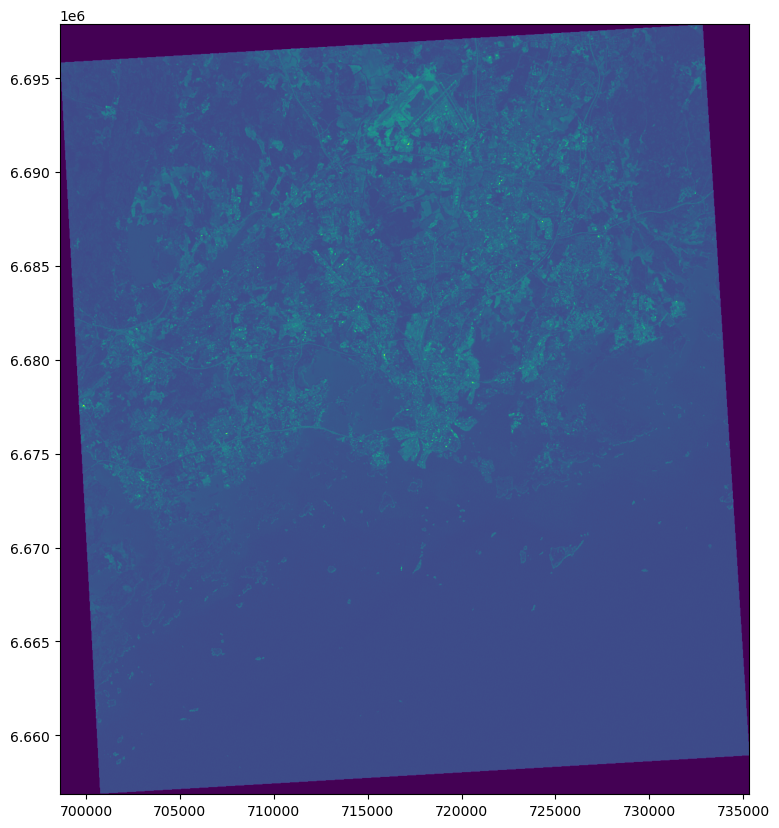

In [30]:
data_dir = 'data/L5/L5_data'
fp = os.path.join(data_dir, 'Helsinki_masked_p188r018_7t20020529_z34__LV-FIN.tif')

# Open file
raster = rasterio.open(fp)

fig, ax = plt.subplots(figsize = (10, 10))
show((raster, 1), ax = ax)
plt.show()

Here we can see that the `show` function created a map showing the pixel values of band 1.

Let’s see how the different bands look like by placing them next to each other:

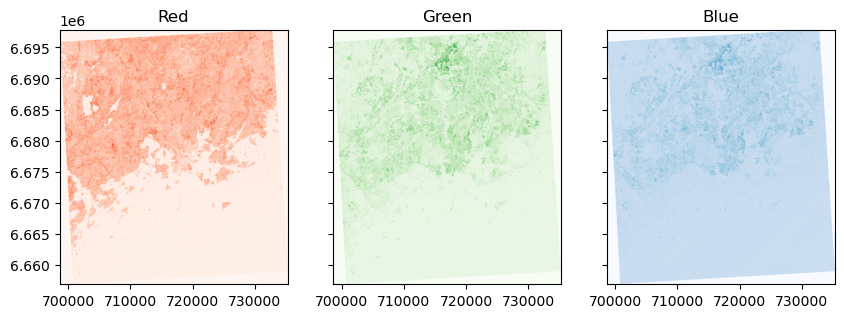

In [31]:
# Initialize subplots
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, nrows = 1, figsize = (10, 4), sharey = True)

# Plot Red, Green, Blue (rgb)
show((raster, 4), cmap = 'Reds', ax = ax1)
show((raster, 3), cmap = 'Greens', ax = ax2)
show((raster, 1), cmap = 'Blues', ax = ax3)

# Add titles
ax1.set_title('Red')
ax2.set_title('Green')
ax3.set_title('Blue')

plt.show()

## RGB True color composite

Next let’s see how we can plot these channels as a normal RGB image.

First,  we need to read the bands into numpy arrays and normalize the cell values into scale ranging from 0.0 to 1.0:

In [33]:
# Read the grid values into numpy arrays
red = raster.read(3)
green = raster.read(2)
blue = raster.read(1)

# Function to normalize the grid values
def normalize(array):
    '''Normalize numpy arrays into scale 0.0 - 1.0'''
    array_min, array_max = array.min(), array.max()
    return ((array - array_min) / (array_max - array_min))

# Normalize the bands
red_n = normalize(red)
green_n = normalize(green)
blue_n = normalize(blue)

print('Normalized bands')
for n in [red_n, green_n, blue_n]:
    print(n.min(), '-', n.max(),'mean: ', n.mean())

Normalized bands
0.0 - 1.0 mean:  0.1423301480606746
0.0 - 1.0 mean:  0.16915069862129217
0.0 - 1.0 mean:  0.23384832284425988


As the statistics show, now the arrays have been normalized into scale from 0 to 1.

Next we need to stack the values from different values together to produce the RGB true color composite. For this we can use Numpy’s `dstack()` function:

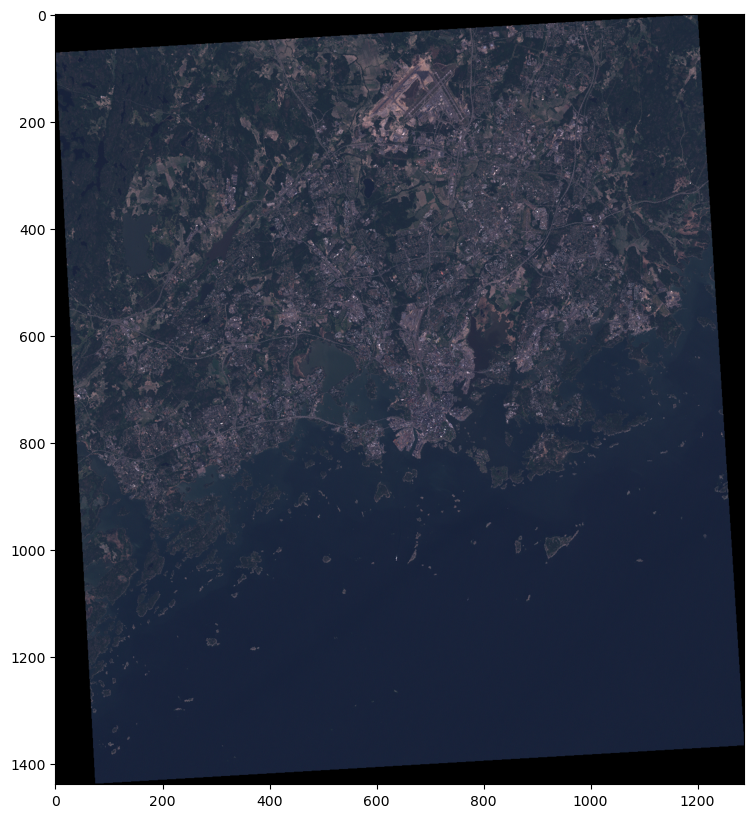

In [35]:
# Create RGB natural color composite
rgb = np.dstack((red_n, green_n, blue_n))

# Let's see how our color composite looks like
plt.figure(figsize = (10, 10))
plt.imshow(rgb)
plt.show()

Here, we have a typical RGB natural color composite image that looks like a photograph taken with the satellite.

## False color composite

Following the previous example, it is easy to create false color composites with different band configurations.

One of the typical one, is to replace the blue band with near infra-red that can be used to detect vegetation easily where red color is emphasized. Let’s use the same raster file as input, and generate our first false color composite:

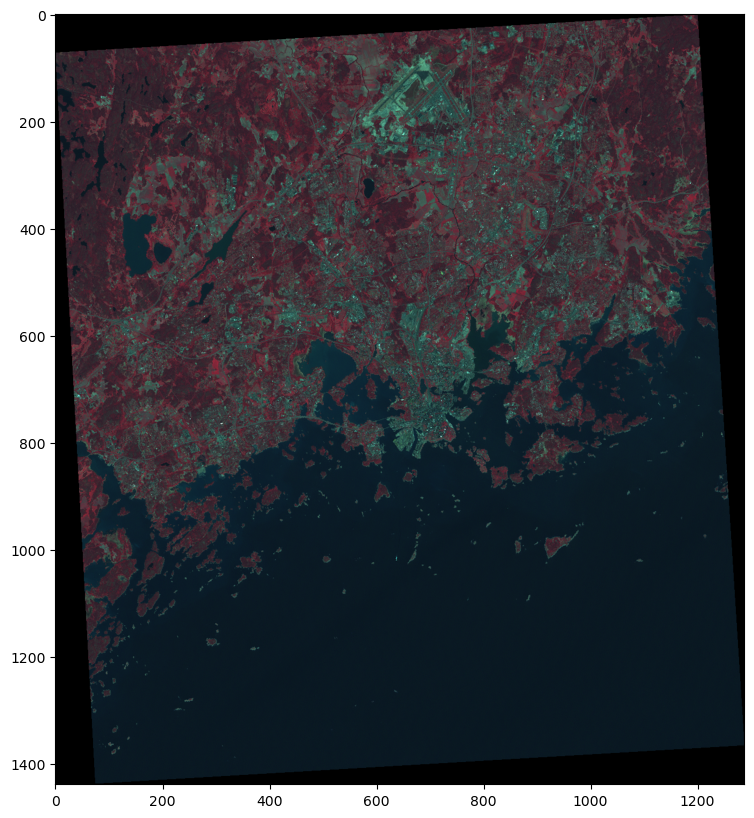

In [36]:
# Read the grid values into numpy arrays
nir = raster.read(4)
red = raster.read(3)
green = raster.read(2)

# Normalize the values using the function that we defined earlier
nir_n = normalize(nir)
red_n = normalize(red)
green_n = normalize(green)

# Create the composite by stacking
nrg = np.dstack((nir_n, red_n, green_n))

# Let's see how our color composite looks like
plt.figure(figsize = (10, 10))
plt.imshow(nrg)
plt.show()

As we can see, now the vegetation can be seen more easily from the image (red color).

## Histogram of the raster data

Typically when working with raster data, you want to look at the histogram of different bands in your data. Luckily that is really easy to do with rasterio by using the `plot.show_hist()` function.

We can easily see how the wavelengths of different bands are distributed.

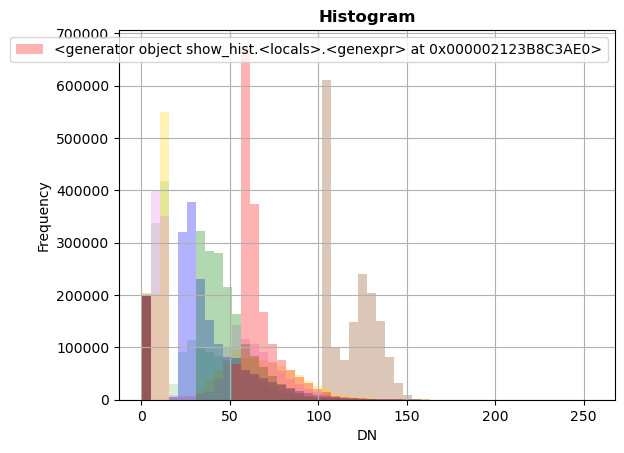

In [37]:
show_hist(raster, bins = 50, lw = 0.0, stacked = False, alpha = 0.3,
        histtype = 'stepfilled', title = 'Histogram')

# Masking / clipping raster

One common task in raster processing is to clip raster files based on a Polygon. The following example shows how to clip a large raster based on a bounding box around Helsinki Region.

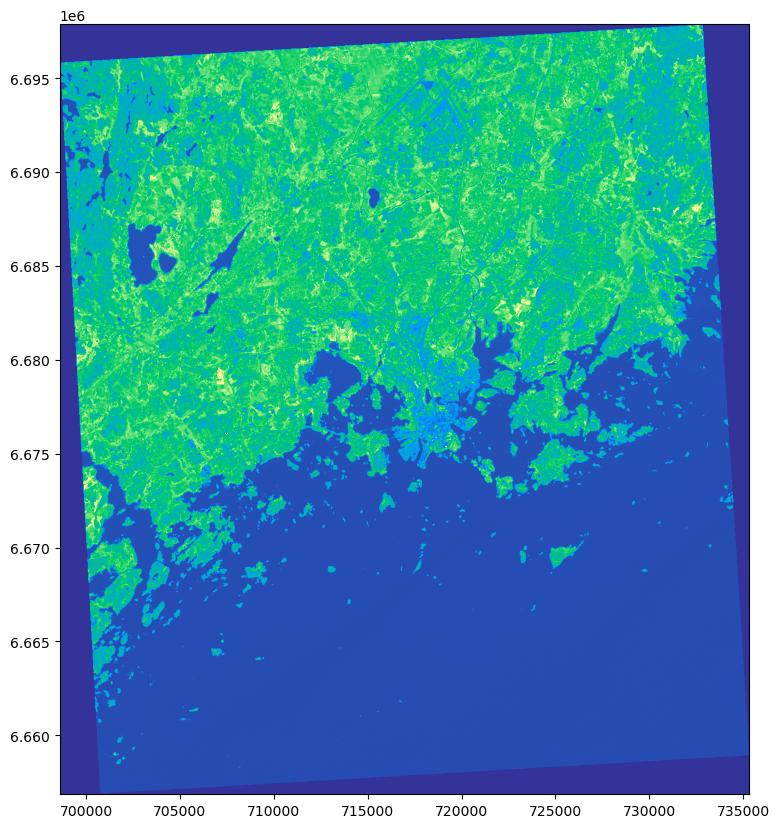

In [40]:
data_dir = 'data/L5/L5_data/'
fp = os.path.join(data_dir, 'Helsinki_masked_p188r018_7t20020529_z34__LV-FIN.tif')
out_tif = os.path.join(data_dir, 'Helsinki_Masked.tif')

data = rasterio.open(fp)

plt.figure(figsize = (10, 10))
show((data, 4), cmap = 'terrain')
plt.show()

We have a huge raster file where we can see the coastlines of Finland and Estonia. What we want to do next is to create a bounding box around Helsinki region and clip the raster based on that.

In [44]:
# WGS84 coordinates
minx, miny = 24.60, 60.00
maxx, maxy = 25.22, 60.35
bbox = box(minx, miny, maxx, maxy)

geo = gpd.GeoDataFrame({'geometry': bbox}, index = [0], crs = from_epsg(4326))
geo

c:\Users\gilramolete\Anaconda3\envs\pls\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


geometry
0  POLYGON ((25.22000 60.00000, 25.22000 60.35000...

As we can see now we have a GeoDataFrame with Polygon inside. To be able to clip the raster with this Polygon, it is required that the data has identical coordinate reference system.

Re-project into the same coordinate system as the raster data. We can access the crs of the raster using attribute `.crs.data`. Also, we need to get the coordinates of the geometry in such a format that rasterio wants them.

In [93]:
# Project the polygon into same the same CRS as the grid
geo = geo.to_crs('epsg:32634') # can't find it
geo.crs

<Derived Projected CRS: EPSG:32634>
Name: WGS 84 / UTM zone 34N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 18°E and 24°E, northern hemisphere between equator and 84°N, onshore and offshore. Albania. Belarus. Bosnia and Herzegovina. Bulgaria. Central African Republic. Chad. Croatia. Democratic Republic of the Congo (Zaire). Estonia. Finland. Greece. Hungary. Italy. Kosovo. Latvia. Libya. Lithuania. Montenegro. North Macedonia. Norway, including Svalbard and Bjornoys. Poland. Romania. Russian Federation. Serbia. Slovakia. Sudan. Sweden. Ukraine.
- bounds: (18.0, 0.0, 24.0, 84.0)
Coordinate Operation:
- name: UTM zone 34N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [94]:
def getFeatures(gdf):
    '''Function to parase features from GeoDataFrame in such a manner that rasterio wants them'''
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

coords = getFeatures(geo)
coords

[{'type': 'Polygon',
  'coordinates': [[[735275.3533476032, 6658919.843253607],
    [732783.5561207377, 6697846.086795724],
    [698608.1329965615, 6695816.080575279],
    [700733.5832412291, 6656875.248540205],
    [735275.3533476032, 6658919.843253607]]]}]

As we can see, rasterio wants to have the coordinates of the Polygon in GeoJSON format.

Now we are ready to clip the raster with the polygon using the coords variable that we just created. Clipping the raster can be done easily with the mask function that we imported in the beginning from rasterio, and specifying clip=True. We will then modify the metadata and parse the EPSG value from the CRS so that we can create a `Proj4`-string using `PyCRS` library (to ensure that the projection information is saved correctly).

In [112]:
# Clip the raster with Polygon
out_img, out_transform = mask(dataset = data, shapes = coords, crop = True)

# Copy the metadata
out_meta = data.meta.copy()
print(out_meta)

# Parse EPSG code
# epsg_code = int(data.crs.data['init'][5:])
epsg_code = int(geo.crs.srs[-5:])
print(epsg_code)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1288, 'height': 1439, 'count': 7, 'crs': CRS.from_wkt('PROJCS["UTM Zone 0, Northern Hemisphere",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-183],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(28.5, 0.0, 698592.0,
       0.0, -28.5, 6697870.5)}
32634


Now we need to update the metadata with new dimensions, transform (affine) and CRS (as Proj4 text). Then we can save the clipped raster to disk and check the result.

In [116]:
# out_meta.update({
#     'driver': 'GTiff',
#     'height': out_img.shape[1],
#     'width': out_img.shape[2],
#     'transform': out_transform,
#     'crs': pycrs.parse.from_epsg_code(epsg_code).to_proj4()
# })

# with rasterio.open(out_tif, 'w', **out_meta) as dest:
#     dest.write(out_img)

# # Open the clipped raster file
# clipped = rasterio.open(out_tif)

# # Visualize
# plt.figure(figsize = (10, 10))
# show((clipped, 5), cmap = 'terrain')
# plt.show()

# Raster map algebra

Conducting calculations between bands or raster is another common GIS task. Here, we will be calculating NDVI (Normalized difference vegetation index) based on the Landsat dataset that we have downloaded from Helsinki region. Conducting calculations with rasterio is fairly straightforward if the extent etc. matches because the values of the rasters are stored as numpy arrays (similar to the columns stored in Geo/Pandas, i.e. Series). Here, we will see how to calculate the NDVI (Normalized difference vegetation index) based on two bands: band-4 which is the Red channel and band-5 which is the Near Infrared (NIR).

Let’s start by importing the necessary modules `rasterio` and `numpy` and reading the raster file that we masked for Helsinki Region:

Red:  36.29418775547201
NIR:  35.0946303937776
<class 'numpy.ndarray'>


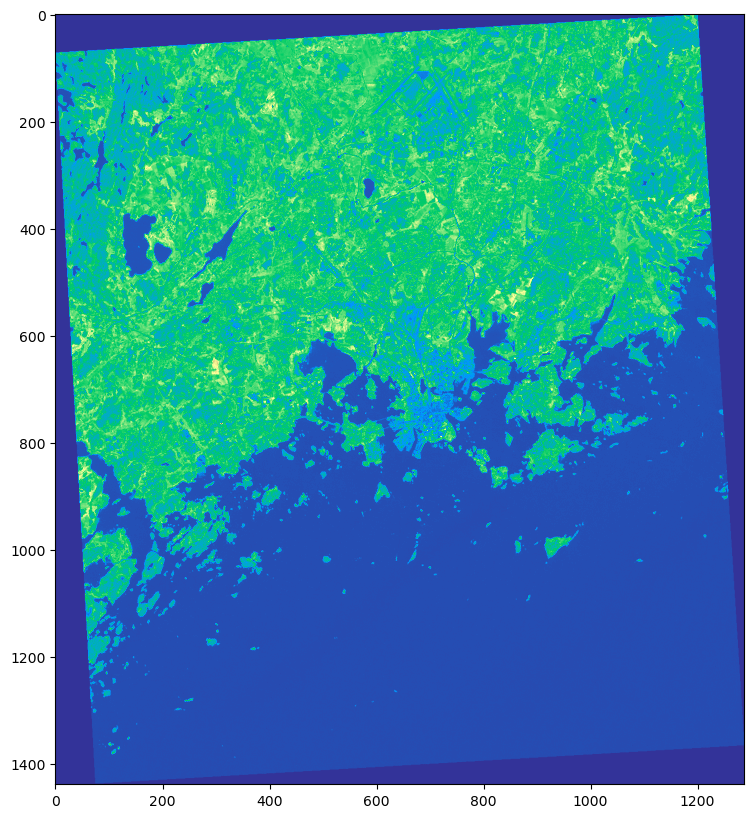

In [117]:
# Data dir
data_dir = 'data/L5/L5_data/'

# Filepath
fp = os.path.join(data_dir, 'Helsinki_masked_p188r018_7t20020529_z34__LV-FIN.tif')

# Open the raster file in read mode
raster = rasterio.open(fp)

# Read red channel (channel number 3)
red = raster.read(3)
# Read NIR channel (channel number 4)
nir = raster.read(4)

# Calculate some stats
print("Red: ", red.mean())
print('NIR: ', nir.mean())
print(type(nir))

# Visualize
plt.figure(figsize = (10, 10))
show(nir, cmap = 'terrain')
plt.show()

As we can see the values are stored as `numpy.ndarray`. From the map we can see that NIR channel reflects strongly (light green) in areas outside the Helsinki urban areas.

Let’s change the data type from uint8 to float so that we can have floating point numbers stored in our arrays:

In [118]:
# Convert to floats
red = red.astype('f4')
nir = nir.astype('f4')
nir

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Now we can see that the numbers changed to decimal numbers (there is a dot after the zero).

Next we need to tweak the behaviour of numpy a little bit. By default numpy will complain about dividing with zero values. We need to change that behaviour because we have a lot of 0 values in our data.

In [119]:
np.seterr(divide = 'ignore', invalid = 'ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Now we are ready to calculate the NDVI. This can be done easily with simple map algebra and using the NDVI formula and passing our numpy arrays into it:

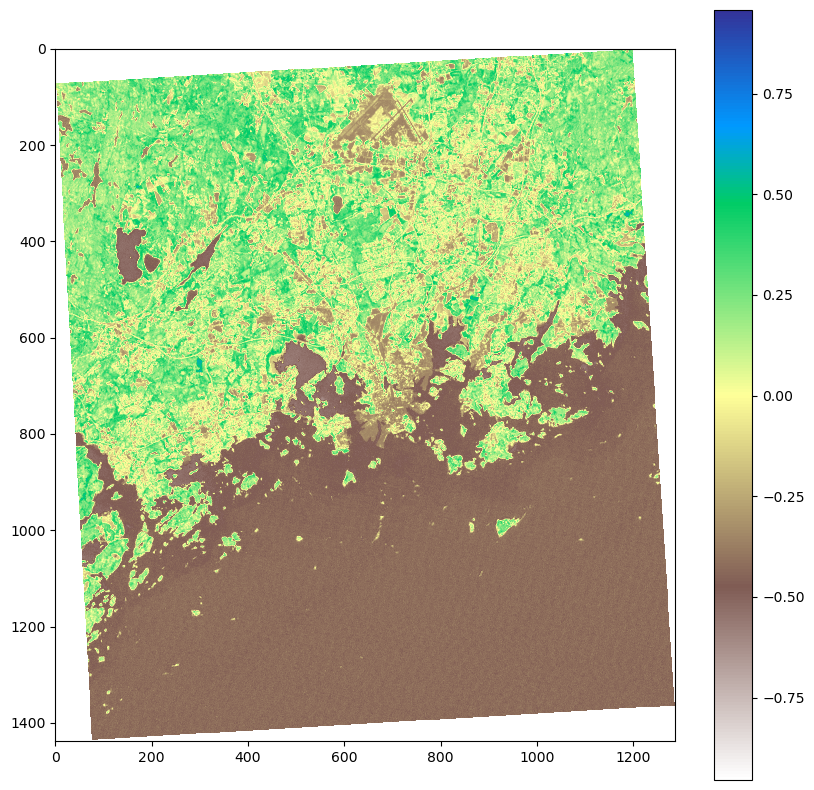

In [120]:
# Calculate NDVI using numpy arrays
ndvi = (nir - red) / (nir + red)

# Plot the NDVI
plt.figure(figsize = (10, 10))
plt.imshow(ndvi, cmap = 'terrain_r')
plt.colorbar() # Add colorbar to show the index
plt.show()

As we can see from the map, now the really low NDVI indices are located in water and urban areas (middle of the map) whereas the areas colored with green have a lot of vegetation according our NDVI index.

# Creating a raster mosaic

Quite often you need to merge multiple raster files together and create a `raster` `mosaic`. This can be done easily with the `merge()` function in Rasterio.

Here, we will create a mosaic based on 2X2m resolution DEM files (altogether 12 files) covering the Helsinki Metropolitan region. If you have not downloaded the DEM files yet, you can do that by running the script from download-data -section of the tutorial.

As there are many `tif` files in our folder, it is not really pracical to start listing them manually. Luckily, we have a module and function called `glob` that can be used to create a list of those files that we are interested in based on search criteria.

Let’s start by:
- Importing required modules
- Finding all `tif` files from the folder where the file starts with `L` letter.

In [124]:
# File and folder paths
dirpath = 'data/L5/Automate/'
out_fp = os.path.join(dirpath, 'Helsinki_DEM2x2m_Mosaic.tif')

# Make a search criteria to select the DEM files
search_criteria = 'L*.tif'
q = os.path.join(dirpath, search_criteria)
print(q)

data/L5/Automate/L*.tif


In [125]:
# Glob function can be used to list files from a directory with a specific criteria
dem_fps = glob.glob(q)
dem_fps

['data/L5/Automate\\L4133A.tif',
 'data/L5/Automate\\L4133B.tif',
 'data/L5/Automate\\L4133C.tif',
 'data/L5/Automate\\L4133D.tif',
 'data/L5/Automate\\L4133E.tif',
 'data/L5/Automate\\L4133F.tif',
 'data/L5/Automate\\L4134A.tif',
 'data/L5/Automate\\L4134B.tif',
 'data/L5/Automate\\L4134C.tif',
 'data/L5/Automate\\L4134D.tif',
 'data/L5/Automate\\L4134E.tif',
 'data/L5/Automate\\L4134F.tif']

Great! Now we have all those 12 files in a list and we can start to make a mosaic out of them.

Let’s first create a list for the source raster datafiles (in read mode) with rasterio that will be used to create the mosaic:

In [132]:
# List for the source files
src_files_to_mosaic = []

# Iterate over raster files and add them to source -list in 'read mode'
for fp in dem_fps:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)

src_files_to_mosaic

[<open DatasetReader name='data/L5/Automate\L4133A.tif' mode='r'>,
 <open DatasetReader name='data/L5/Automate\L4133B.tif' mode='r'>,
 <open DatasetReader name='data/L5/Automate\L4133C.tif' mode='r'>,
 <open DatasetReader name='data/L5/Automate\L4133D.tif' mode='r'>,
 <open DatasetReader name='data/L5/Automate\L4133E.tif' mode='r'>,
 <open DatasetReader name='data/L5/Automate\L4133F.tif' mode='r'>,
 <open DatasetReader name='data/L5/Automate\L4134A.tif' mode='r'>,
 <open DatasetReader name='data/L5/Automate\L4134B.tif' mode='r'>,
 <open DatasetReader name='data/L5/Automate\L4134C.tif' mode='r'>,
 <open DatasetReader name='data/L5/Automate\L4134D.tif' mode='r'>,
 <open DatasetReader name='data/L5/Automate\L4134E.tif' mode='r'>,
 <open DatasetReader name='data/L5/Automate\L4134F.tif' mode='r'>]

As we can see, now the list contains all those files as raster objects in read mode (`´mode = ‘r’´`).

Let’s plot a few of them next to each other to see how they look like:

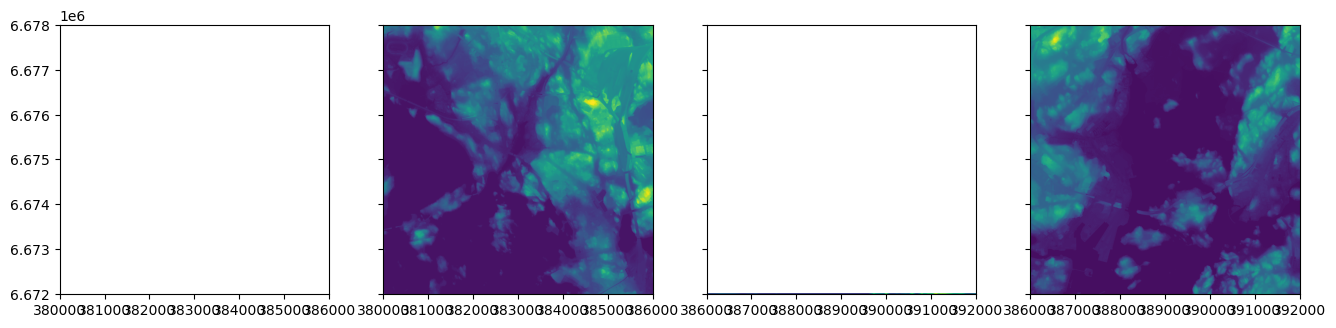

In [134]:
# Create 4 plots next to each other
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, nrows = 1, figsize = (16, 4), sharey = True)

# Plot first four files
show(src_files_to_mosaic[0], ax = ax1)
show(src_files_to_mosaic[1], ax = ax2)
show(src_files_to_mosaic[2], ax = ax3)
show(src_files_to_mosaic[3], ax = ax4)

plt.show()

As we can see we have multiple separate raster files that are actually located next to each other. Hence, we want to put them together into a single raster file that can by done by creating a raster mosaic.

Now as we have placed the individual raster files in read -mode into the `source_files_to_mosaic` list, it is really easy to merge those together and create a mosaic with rasterio’s `merge` function:

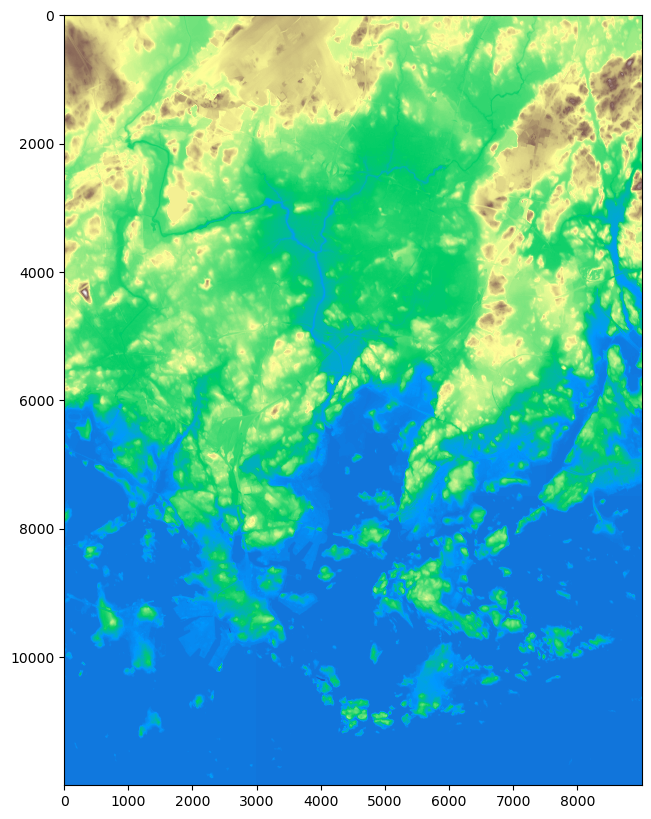

In [138]:
# Merge function returns a single mosaic array and the transformation info
mosaic, out_trans = merge(src_files_to_mosaic)

# Plot the result
plt.figure(figsize = (10, 10))
show(mosaic, cmap = 'terrain')
plt.show()

Great, it looks correct! Now we are ready to save our mosaic to disk.

Let’s first update the metadata with our new dimensions, transform and CRS. Then we can write our mosaic to our computer.

In [139]:
# Copy the metadata
out_meta = src.meta.copy()

# Update the metadata
out_meta.update({
    'driver': 'GTiff',
    'height': mosaic.shape[1],
    'width': mosaic.shape[2],
    'transform': out_trans,
    'crs': '+proj=utm +zone=35 +ellps=GRS80 +units=m +no_defs '
})

# Write the mosaic raster to disk
with rasterio.open(out_fp, 'w', **out_meta) as dest:
    dest.write(mosaic)

# Zonal statistics

Quite often you have a situtation when you want to summarize raster datasets based on vector geometries, such as calculating the average elevation of specific area.

Rasterstats is a Python module that does exactly that, easily.

In [141]:
data_dir = 'data/L5/Automate/'
dem_fp = os.path.join(data_dir, 'Helsinki_DEM2x2m_Mosaic.tif')

# Read the Digital Elevation Model for Helsinki
dem = rasterio.open(dem_fp)
dem

<open DatasetReader name='data/L5/Automate/Helsinki_DEM2x2m_Mosaic.tif' mode='r'>

Good, now our elevation data is in read mode.

Next, we want to calculate the elevation of two neighborhoods located in Helsinki, called `Kallio` and `Pihlajamäki`, and find out which one of them is higher based on the elevation data. We will use a package called OSMnx to fetch the data from OpenStreetMap for those areas.

Specify place names for `Kallio` and `Pihlajamäki` that Nominatim can identify:

In [147]:
# Keywords that can be found from OSM
kallio_q = 'Kallio, Helsinki, Finland'
pihlajamaki_q = 'Pihlajamäki, Malmi, Helsinki, Finland'

# Retrieve the geometries of those areas using osmnx
kallio = ox.geocode_to_gdf(kallio_q)
pihlajamaki = ox.geocode_to_gdf(pihlajamaki_q)

# Reproject to same coordinate system
kallio = kallio.to_crs(crs = dem.crs)
pihlajamaki = pihlajamaki.to_crs(crs = dem.crs)

print(kallio)
print(pihlajamaki)

                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((385383.185 6673603.850, 385458.956 6...   60.187504    60.17636   

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat        lon  \
0  24.961987  24.933454  298383105  relation  184765  60.183982  24.952451   

                                        display_name     class  \
0  Kallio, Central major district, Helsinki, Hels...  boundary   

             type  importance  
0  administrative    0.755246  
                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((389114.010 6679654.219, 389176.580 6...   60.241477   60.229115   

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat       lon  \
0  25.022333  24.997364  298375718  relation  190370  60.235259  25.01096   

                                        display_name     class  \
0  Pihlajamäki, Malmi, Northeastern major distric...  boundary   

             type  importance  
0  a

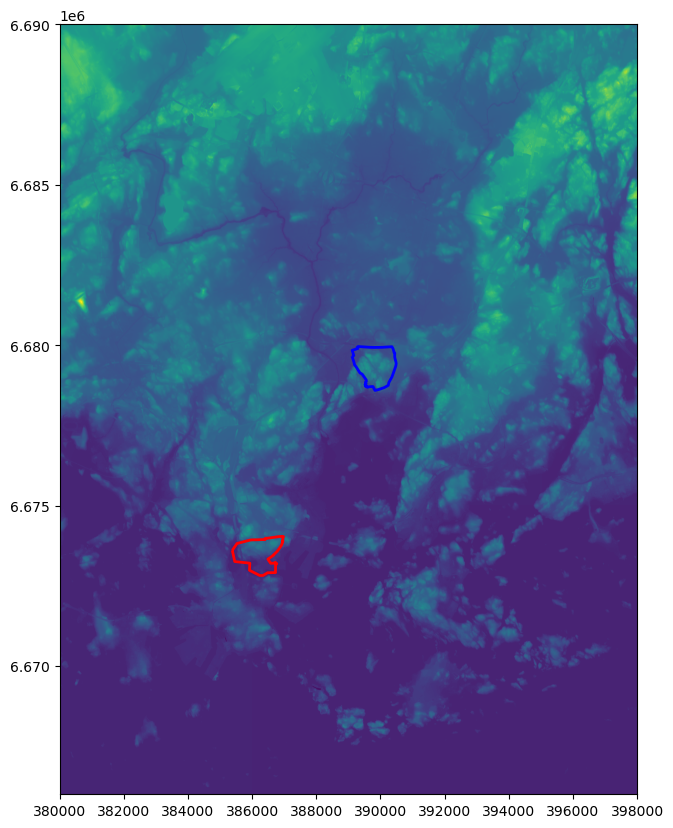

In [148]:
# Plot the polygon on top of the DEM
fig, ax = plt.subplots(figsize = (10, 10))

kallio.plot(ax = ax, facecolor = 'None', edgecolor = 'red', linewidth = 2)
pihlajamaki.plot(ax = ax, facecolor = 'None', edgecolor = 'blue', linewidth = 2)

# Plot DEM
show((dem, 1), ax = ax)
plt.show()

**Which one is higher? Kallio or Pihlajamäki? We can use zonal statistics to find out!**

First we need to get the values of the dem as numpy array and the affine of the raster. Then, we can calculate the zonal statistics by using the function `zonal_stats`.

In [149]:
# Read the raster values
array = dem.read(1)

# Get the affine
affine = dem.transform

# Calculate zonal statistics for Kallio
zs_kallio = zonal_stats(kallio, array, affine = affine, stats = ['min', 'max', 'mean', 'median', 'majority'])
zs_pih = zonal_stats(pihlajamaki, array, affine = affine, stats = ['min', 'max', 'mean', 'median', 'majority'])

print('Zonal statistics for Kallio: ', zs_kallio)
print('Zonal statistics for Pihlajamaki: ', zs_pih)

Zonal statistics for Kallio:  [{'min': -2.1760001182556152, 'max': 37.388999938964844, 'mean': 12.987389199328922, 'median': 11.833999633789062, 'majority': 0.3490000069141388}]
Zonal statistics for Pihlajamaki:  [{'min': 8.621999740600586, 'max': 46.30400085449219, 'mean': 24.559830083614287, 'median': 24.177000045776367, 'majority': 10.41100025177002}]


c:\Users\gilramolete\Anaconda3\envs\pls\Lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
c:\Users\gilramolete\Anaconda3\envs\pls\Lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


# Read Cloud Optimized Geotiffs

The following materials are based on this tutorial. Read more from that tutorial until this one get’s better updated.

Let’s read a Landsat TIF profile from AWS cloud storage:

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7821, 'height': 7951, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(30.0, 0.0, 204285.0,
       0.0, -30.0, 4268115.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
Decimation factor =  81
Array type:  <class 'numpy.ndarray'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


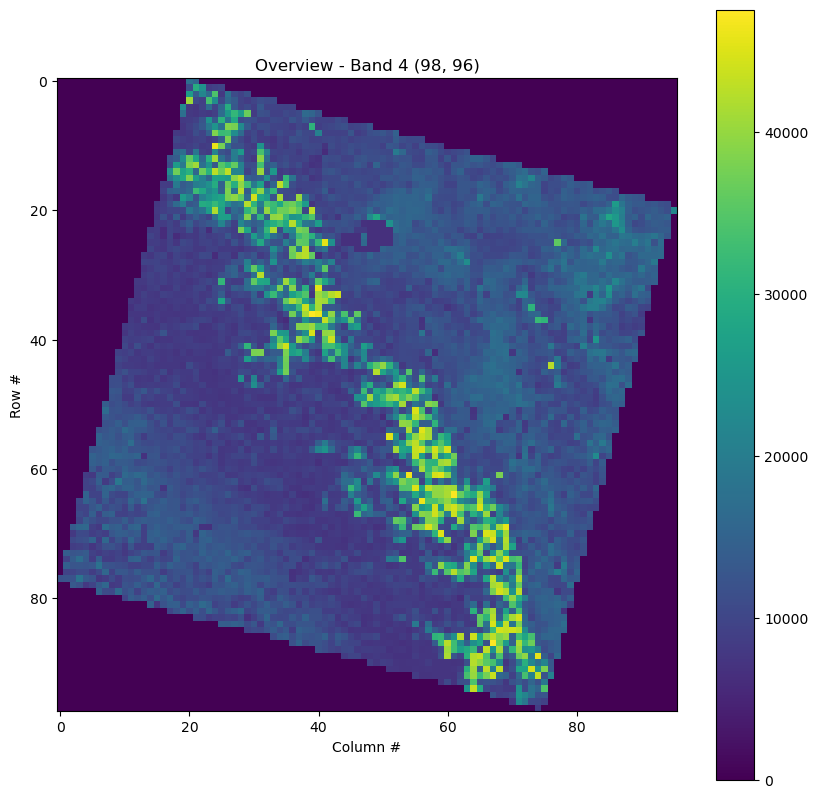

In [174]:
# Specify the path for Landsat TIF on AWS
fp = 'data/L5/L5_data/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF'

# See the profile
with rasterio.open(fp) as src:
    print(src.profile)

# Open the COG
with rasterio.open(fp) as src:
    # List of overviews from biggest to smallest
    oviews = src.overviews(1)

    # Retrieve the smallest thumbnail
    # oview = oviews[0] # doesn't work
    oview = 81
    print('Decimation factor = ', oview)
    # NOTE this is using a 'decimated read' (http://rasterio.readthedocs.io/en/latest/topics/resampling.html)
    thumbnail = src.read(1, out_shape = (1, int(src.height // oview), int(src.width // oview)))

print('Array type: ', type(thumbnail))
print(thumbnail)

plt.figure(figsize = (10, 10))
plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

plt.show()

Let's fix the NoData values to be `NaN` instead of 0.

Decimnation factor =  81


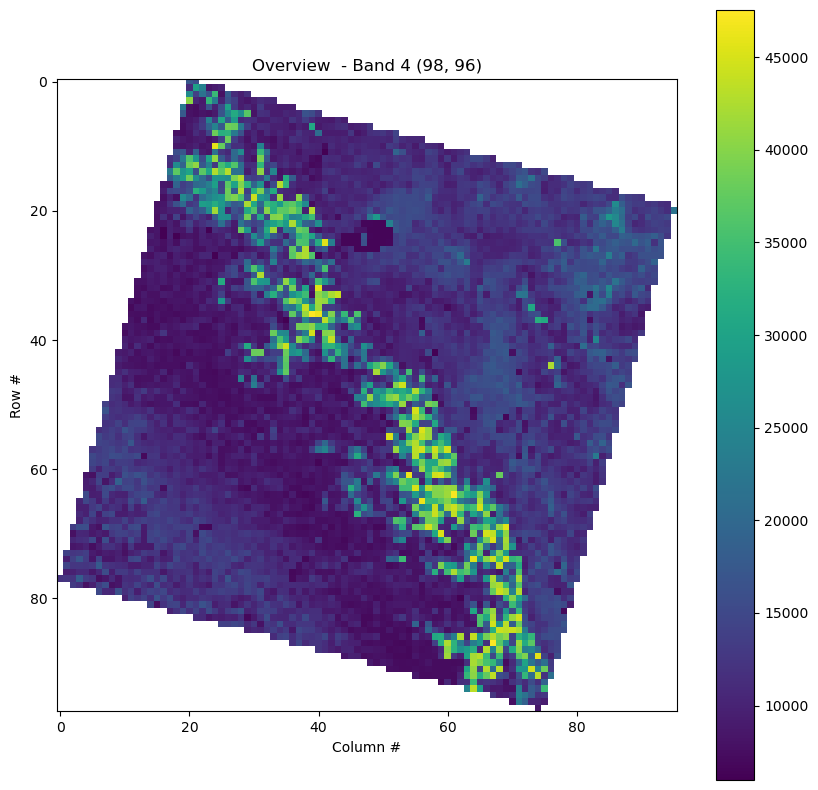

In [175]:
# Open the file
with rasterio.open(fp) as src:
    # Access the overviews
    oviews = src.overviews(1)
    # oview = oviews[-1]
    oview = 81

    print('Decimnation factor = ', oview)

    # Read the thumbnail
    thumbnail = src.read(1, out_shape = (1, int(src.height // oview), int(src.width // oview)))

    # Convert the values into float
    thumbnail = thumbnail.astype('f4')

    # Convert 0 values to NaNs
    thumbnail[thumbnail == 0] = np.nan

plt.figure(figsize = (10, 10))
plt.imshow(thumbnail)
plt.colorbar()
plt.title(f'Overview  - Band 4 {thumbnail.shape}')
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()

Let's take the subset from the high resolution image.

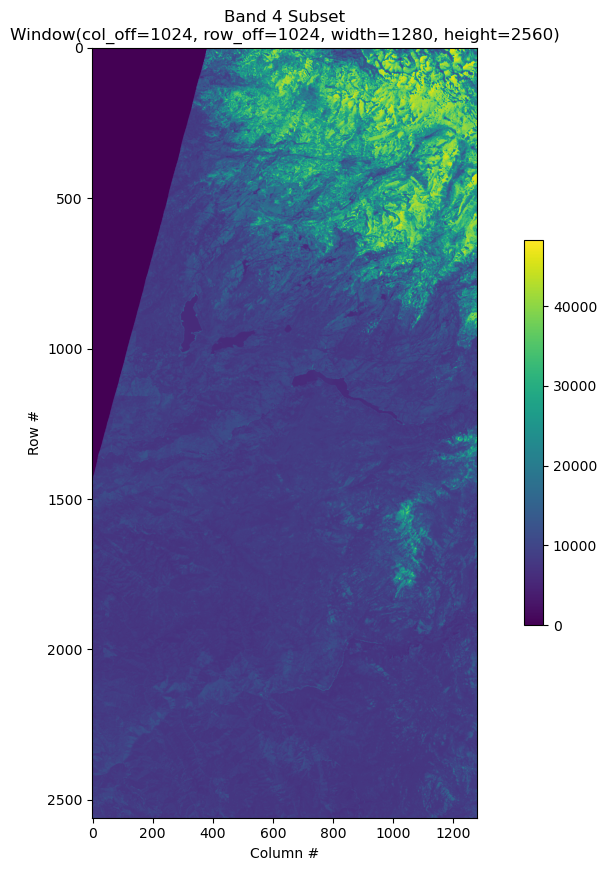

In [176]:
# https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html
# rasterio.windows.Window(col_off, row_off, width, height)
window = rasterio.windows.Window(1024, 1024, 1280, 2560)

with rasterio.open(fp) as src:
    subset = src.read(1, window = window)

plt.figure(figsize = (12, 10))
plt.imshow(subset)
plt.colorbar(shrink = 0.5)
plt.title(f'Band 4 Subset\n{window}')
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()